# Cell segmentation on MERFISH dataset

In [1]:
import spateo as st
import numpy as np
import pandas as pd

2023-05-31 09:38:36.940502: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/panhailin/miniconda3/envs/spateo/lib/python3.8/site-packages/spaghetti-1.6.5-py3.8.egg/spaghetti/network.py:36: FutureWarning:

The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.



|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


Prepare input file for Starro

In [2]:
df = pd.read_csv('fov100.input.csv', index_col=0)
df

,global_x,global_y,global_z,target_molecule_name
Unnamed: 0,,,,
3745057,-898.36430,1944.3198,0.0,Gfap
3745058,-892.43160,1945.2063,0.0,Gfap
3750240,-891.88983,1951.2223,1.5,Cux2
3750242,-892.24036,1952.1198,1.5,Cux2
3750244,-891.66235,1952.7710,1.5,Cux2
...,...,...,...,...
4676026,-1097.04850,2162.9368,7.5,Slc30a3
4676839,-1097.99320,2159.1230,7.5,Wipf3
4676840,-1104.56120,2160.7954,7.5,Wipf3


In [3]:
df['x'] = (df['global_x']/0.5).round().astype(np.int32)
df['y'] = (df['global_y']/0.5).round().astype(np.int32)
print(df['x'].min())
print(df['y'].min())
df['x'] -= df['x'].min()
df['y'] -= df['y'].min()
df = df[['x', 'y', 'target_molecule_name']]
df.columns = ['x', 'y', 'geneID']
df['MIDCount'] = 1
df['EXONIC'] = 1
df['INTRONIC'] = 1
df

-2219
3884


,x,y,geneID,MIDCount,EXONIC,INTRONIC
Unnamed: 0,,,,,,
3745057,422,5,Gfap,1,1,1
3745058,434,6,Gfap,1,1,1
3750240,435,18,Cux2,1,1,1
3750242,435,20,Cux2,1,1,1
3750244,436,22,Cux2,1,1,1
...,...,...,...,...,...,...
4676026,25,442,Slc30a3,1,1,1
4676839,23,434,Wipf3,1,1,1
4676840,10,438,Wipf3,1,1,1


In [4]:
df.to_csv('m1s1fov100.gem.gz', index=False, sep='\t')

Read in data file and change it ot adata

In [5]:
adata = st.io.read_bgi_agg('m1s1fov100.gem.gz')

|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


|-----> <select> X layer in AnnData Object


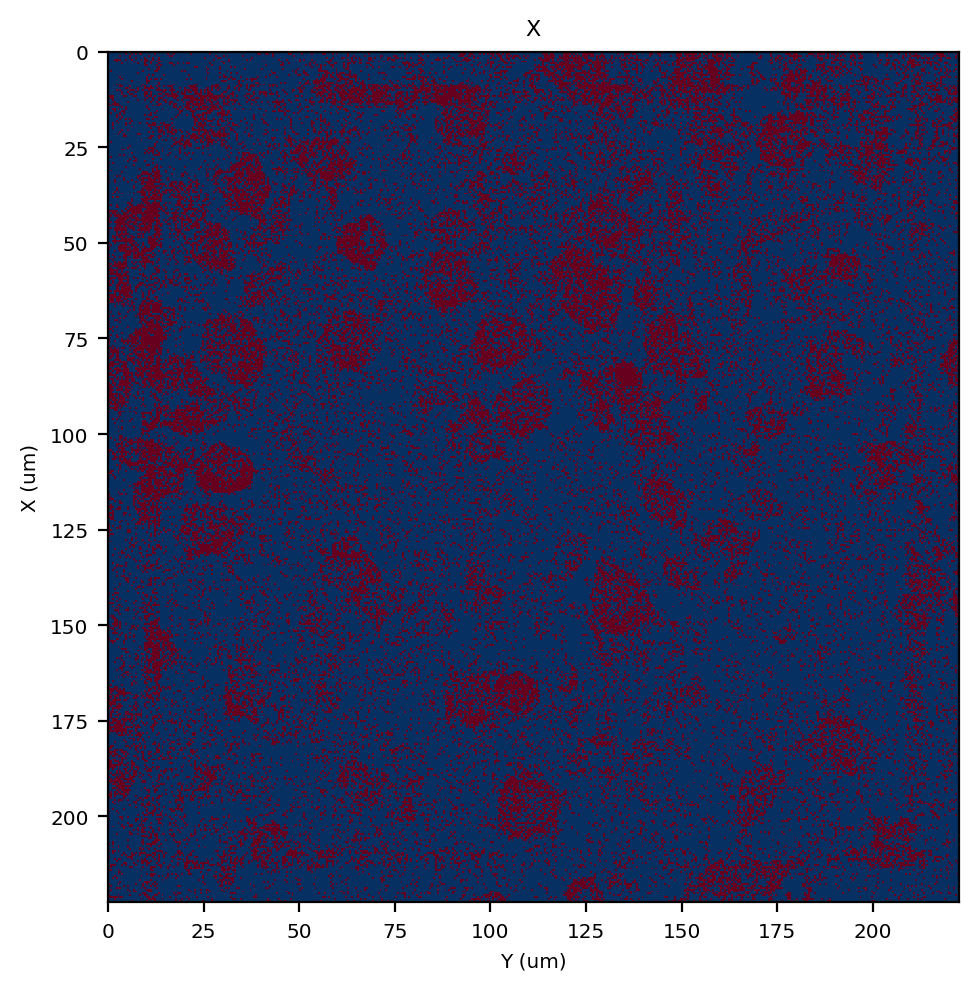

In [6]:
st.pl.imshow(adata, 'X', vmax=1,)

Cell segmetation

|-----> <select> X layer in AnnData Object
|-----> Scoring pixels with gauss method.
|-----> <insert> X_scores to layers in AnnData Object.
|-----> Applying threshold 0.201171875.
threshold: 0.201171875
|-----> <insert> X_mask to layers in AnnData Object.
|-----> <select> X_mask layer in AnnData Object


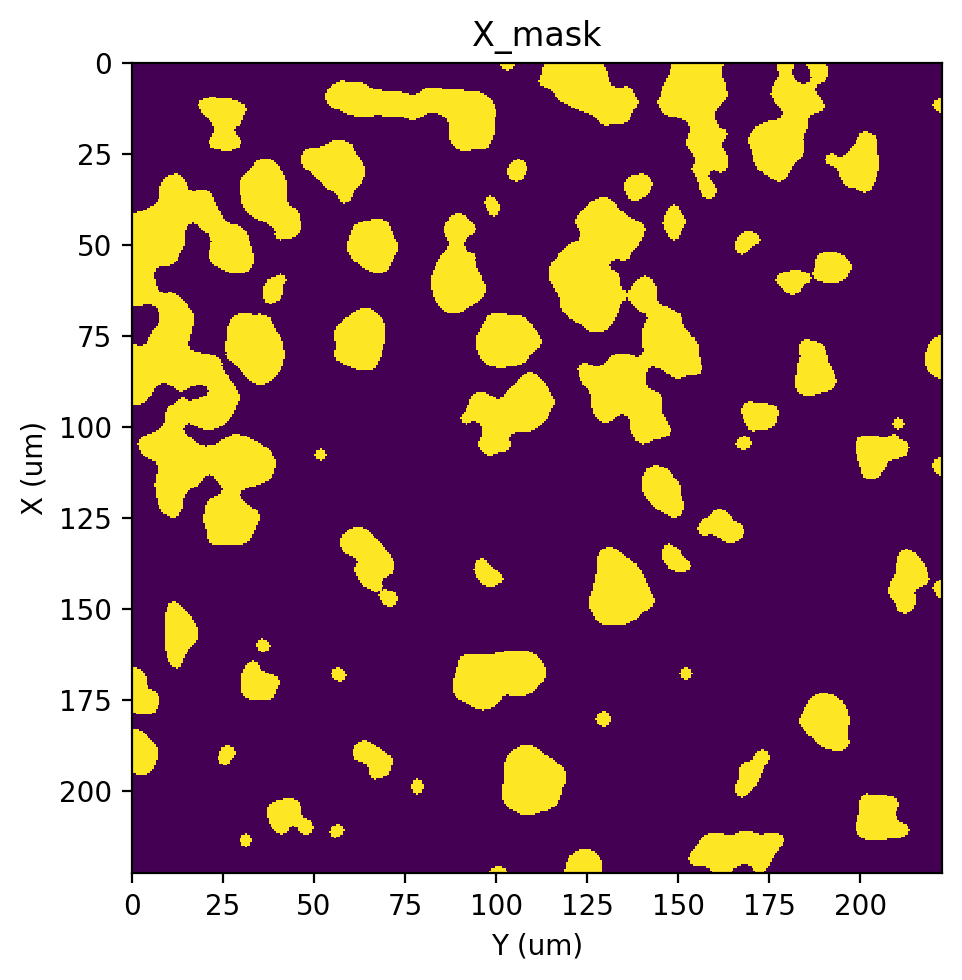

In [7]:
st.cs.score_and_mask_pixels(
    adata, 'X', k=21, method='gauss', mk=7,
)
st.pl.imshow(adata, 'X_mask',)

|-----> <select> X_mask layer in AnnData Object
|-----> Finding Watershed markers with iterative erosion.


Eroding: 18it [00:00, 518.74it/s]

|-----> <insert> X_markers to layers in AnnData Object.
|-----> <select> X layer in AnnData Object
|-----> <select> X_mask layer in AnnData Object
|-----> <select> X_markers layer in AnnData Object
|-----> Running Watershed.
|-----> <insert> starro to layers in AnnData Object.
|-----> <select> starro layer in AnnData Object
|-----> Cell number before filtering is 100
|-----> <insert> starro to layers in AnnData Object.
|-----> Cell number after filtering is 71
|-----> <select> starro layer in AnnData Object


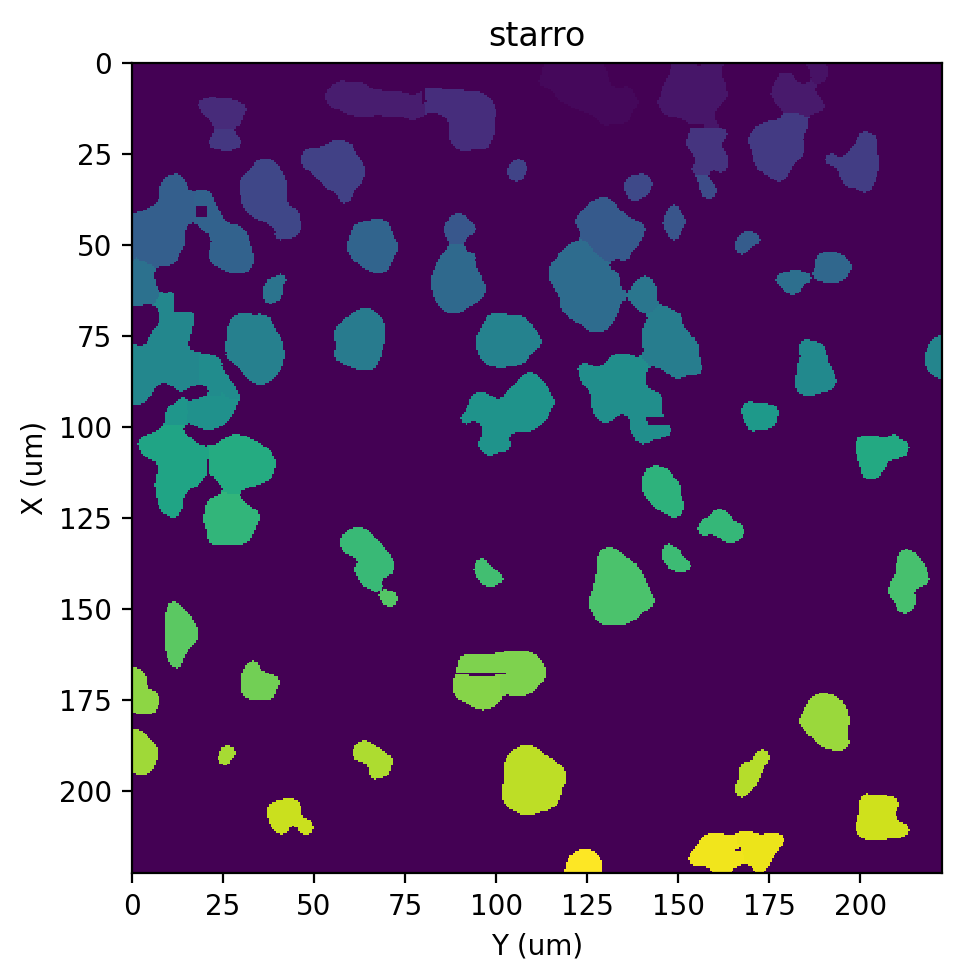

In [8]:
st.cs.find_peaks_with_erosion(adata, layer='X_mask', out_layer='X_markers')
st.cs.watershed(adata, 'X', k=25, mask_layer='X_mask', markers_layer='X_markers', out_layer="starro")
st.cs.utils.filter_cell_labels_by_area(adata, "starro", 70)
st.pl.imshow(adata, 'starro',)